In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4OxV_-HzKd5jlBZhtQk11M_eET2ifSDlDT9eQV4I1p7kK1VEvsKSo
Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/flickr")
!ls

caption  captions.txt  Images


In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


import torchvision.datasets as datasets
import torchvision

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import os
import random
import time

In [ ]:
import transformers

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
print(os.environ.get('CUDA_LAUNCH_BLOCKING'))

None


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'
# REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [ ]:
!kaggle datasets download adityajn105/flickr8k -p ./caption/


/bin/bash: kaggle: command not found


In [ ]:
ROOT='./caption'
datasets.utils.extract_archive('./caption/flickr8k.zip', os.path.join(ROOT, 'flickr'))

FileNotFoundError: [Errno 2] No such file or directory: './caption/flickr8k.zip'

In [ ]:
image_dir = f'Images/'
csv_file = f'captions.txt'

In [ ]:
import pandas as pd

df = pd.read_csv(csv_file, delimiter=',')


In [ ]:
df.tail()

,image,caption
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .
40454,997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wa...


In [ ]:
df['image'].is_unique

False

In [ ]:
df.loc[df['image'] == '997722733_0cb5439472.jpg'] 

,image,caption
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .
40454,997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wa...


In [ ]:
g = df.groupby(["image"]).cumcount().add(1)
df = df.set_index(["image", g]).unstack(fill_value=0).sort_index(axis=1, level=1)
df.columns = ["{}{}".format(a, b) for a, b in df.columns]

df = df.reset_index()

In [ ]:
df['image'] = image_dir+'/'+df['image']
df.rename(columns = {'image':'image_name'}, inplace = True)

In [ ]:
df.head()

,image_name,caption1,caption2,caption3,caption4,caption5
0,Images//1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,Images//1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,Images//1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,Images//1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,Images//1007129816_e794419615.jpg,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...


In [ ]:
from sklearn.model_selection import train_test_split

## Obtain Train and Test Split 
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Reset Indexes 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Obtain Train and Validation Split 
train, val = train_test_split(train, test_size=0.25, random_state=42)

## Reset Indexes 
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

## Let's see how many entries we have
print(train.shape)
print(val.shape)
print(test.shape)

(4854, 6)
(1618, 6)
(1619, 6)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/sudip/anaconda3/envs/env1/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
from torchvision import transforms as CVtransforms
from PIL import Image


class FlickrDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, 
                 transforms= None) -> None:
        self.df = df
        self.transforms = CVtransforms.Compose([
            CVtransforms.Resize((256,256)),
            CVtransforms.ToTensor(),
            CVtransforms.Normalize(mean = [0.5], std = [0.5]),
            
        ])
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int):
        
        image_id = self.df.image_name.values[idx]
        image = Image.open(image_id).convert('RGB')
        #print(image_id)
        #print(type(image))
        if self.transforms is not None:
            image = self.transforms(image)
            
        comments = self.df[self.df.image_name == image_id].values.tolist()[0][1:][0] # Last zero is to obtain the first caption ONLY
        encoded_inputs = tokenizer(comments,
                                   return_token_type_ids = False, 
                                   return_attention_mask = False, 
                                   max_length = 100, 
                                   padding = "max_length",
                                  return_tensors = "pt")
        
        sample = {"image":image,"captions": encoded_inputs["input_ids"].flatten()}
        
        return sample

In [ ]:
batch_size = 32

train_dataset = FlickrDataset(train, transforms = True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, drop_last=True)

val_dataset = FlickrDataset(val, transforms = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,drop_last=True)

test_dataset = FlickrDataset(test, transforms = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,drop_last=True)

In [ ]:
from torchvision import models

class CNN(nn.Module):
    def __init__(self, embed_size):
        super(CNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

In [ ]:
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        ''' Initialize the layers of this model.'''
        super().__init__()
    
        self.hidden_size = hidden_size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size=embed_size, \
                            hidden_size=hidden_size,
                            num_layers=1,
                            bias=True,
                            batch_first=True, 
                            dropout=0, 
                            bidirectional=False,
                           )
        
        self.vocab_size = vocab_size
        self.linear = nn.Linear(hidden_size, vocab_size)                     

    def init_hidden(self, batch_size):
        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))

    def forward(self, features, captions):
        """ Define the feedforward behavior of the model """
        captions = captions[:, :-1]     
        self.batch_size = features.shape[0]
        self.hidden = self.init_hidden(self.batch_size) 
        embeddings = self.word_embeddings(captions)
        
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        lstm_out, self.hidden = self.lstm(embeddings, self.hidden) 
        outputs = self.linear(lstm_out)

        return outputs

    ## Greedy search 
    def sample(self, inputs):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        
        output = []
        batch_size = inputs.shape[0]
        hidden = self.init_hidden(batch_size) 
    
        while True:
            outputs, hidden = self.get_outputs(inputs, hidden) 
            _, max_index = torch.max(outputs, dim=1)
            output.append(max_index.cpu().numpy()[0].item())
            if (tokenizer.convert_ids_to_tokens([max_index])[0] == '[PAD]' or tokenizer.convert_ids_to_tokens([max_index])[0] == '[UNK]'  ):
                break
            
            inputs = self.get_next_word_input(max_index)
            
        return output
    
    
    def modified_beam_search(self, inputs, beams = 2, topk=3):
        batch_size = inputs.shape[0]
        hidden = self.init_hidden(batch_size)
        probDic=dict()
        indexDic=dict()
        hiddenDic=dict()
        
        output = []
        outputs, hidden = self.get_outputs(inputs, hidden)
        _,max_index = torch.max(outputs, dim=1)
        output.append(max_index.cpu().numpy()[0].item())
        inputs = self.get_next_word_input(max_index)
        
        for b in range(beams):
            #print('input shape ',b," ",inputs.shape)
            outputs, hidden = self.get_outputs(inputs, hidden)
            #print('outputs shape ',b," ",outputs.shape)
            if(len(outputs.size())>2):
                outputs = torch.squeeze(outputs)
            logits, max_indices = torch.topk(outputs,k=topk, dim=1)
            
            #print('logits shape ',b," ",logits.shape)
            #print('maxindices shape ',b," ",max_indices.shape)
            probDic[b] = torch.squeeze(F.softmax(logits,dim=1))
            indexDic[b] = torch.squeeze(max_indices)
            hiddenDic[b] = hidden
            inputs = self.get_next_word_input(max_indices)
        
        for i in range(len(probDic)-1):
            dimlst = [topk]*(i+2)
            sz = probDic[i+1].size()
            probDic[i+1] = (probDic[i+1].view(dimlst)*(probDic[i].view([topk]*(i+1)+[1]))).view(sz)
        
        for i in range(len(probDic)-1,0,-1):
            probDic[i-1]=probDic[i-1]*(torch.max(probDic[i],dim=1)[0]).view(probDic[i-1].size())
        
        
        lastInd=torch.Tensor([])
        for i in range(len(probDic)):
            arg = torch.argmax(probDic[i])
            idxarg = None
            if i==0:
                idxarg = [arg//topk]
            else:
                idxarg= [arg//topk,arg%topk]
            
            if i==len(probDic)-1:
                lastInd = indexDic[i][idxarg]
            output.append(indexDic[i][idxarg].cpu().numpy().item())
        
        
        inputs = self.get_next_word_input(torch.unsqueeze(lastInd,0))
        hidden = hiddenDic[beams-1]
        
        
        while True:
            outputs, hidden = self.get_outputs(inputs, hidden) 
            _, max_index = torch.max(outputs, dim=1)
            output.append(max_index.cpu().numpy()[0].item())
            
            if (tokenizer.convert_ids_to_tokens([max_index])[0] == '[PAD]' or tokenizer.convert_ids_to_tokens([max_index])[0] == '[UNK]'  ):
                break
            
            inputs = self.get_next_word_input(max_index)
            
        return output
        
    def get_outputs(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
        outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
        outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)

        return outputs, hidden

    def get_next_word_input(self, max_indice):
        ## Prepare to embed the last predicted word to be the new input of the lstm
        if max_indice.size()[0]>1:
            max_indice = max_indice.view((1,max_indice.size()[0]*max_indice.size()[1]))
            
        inputs = self.word_embeddings(max_indice) # inputs shape : (1, embed_size)
        if len(inputs.size())<3:
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
        
        return inputs

In [ ]:


example_batch = next(iter(train_dataloader))

image, captions = example_batch["image"], example_batch["captions"]
image, captions = image.to(device), captions.to(device)

encoder = CNN(embed_size = 512).to(device)
decoder = RNN(embed_size=512, hidden_size = 512, vocab_size = 40000).to(device)

features = encoder(image)

embed = decoder(features, captions)

print("Image Transformation: ", image.shape, " --> ", features.shape)
print("Captions Transformation: ", captions.shape, " --> ", embed.shape)

Image Transformation:  torch.Size([32, 3, 256, 256])  -->  torch.Size([32, 512])
Captions Transformation:  torch.Size([32, 100])  -->  torch.Size([32, 100, 40000])


In [ ]:
%%capture

vocab_size = 60000
steps_per_epoch = 19069 // 32

encoder = CNN(embed_size = 512).to(device)
decoder = RNN(embed_size=512, hidden_size = 512, vocab_size = vocab_size).to(device)

criterion = nn.CrossEntropyLoss().to(device)
params = list(decoder.parameters()) + list(encoder.embed.parameters())

optimizer = torch.optim.Adam(params, lr=0.001)

In [ ]:

for epoch in range(10):
    for idx, sample in enumerate(train_dataloader):
        if idx > steps_per_epoch:
            break
        
        image, captions = torch.tensor(sample['image']).to(device), torch.tensor(sample['captions']).to(device)
        
        # zero the parameter gradients
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Forward pass
        features = encoder(image)
        outputs = decoder(features, captions)
        
        # Compute the Loss
        loss = criterion(outputs.view(-1, vocab_size), 
                         captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        if(idx%200 == 0):
            stats = 'Epoch [%d], Loss: %.4f' % (epoch, loss.item())
            print('\r' + stats, end="")

<ipython-input-25-d41b63755e0c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, captions = torch.tensor(sample['image']).to(device), torch.tensor(sample['captions']).to(device)


Epoch [9], Loss: 0.23494

In [ ]:
rand = np.random.randint(0,1000)
enc_path = f'./caption/encoder.pth'
dec_path = f'./caption/decoder.pth'


torch.save(encoder.state_dict(), enc_path)
torch.save(decoder.state_dict(), dec_path)

In [ ]:
encoder = CNN(embed_size = 512).to(device)
decoder = RNN(embed_size=512, hidden_size = 512, vocab_size = vocab_size).to(device)

enc_path = f'./caption/encoder.pth'
dec_path = f'./caption/decoder.pth'


encoder.load_state_dict(torch.load(enc_path))
encoder.eval()
decoder.load_state_dict(torch.load(dec_path))
decoder.eval()

RNN(
  (word_embeddings): Embedding(60000, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=60000, bias=True)
)

 a big dog chases a little dog on the grass .                                                                                        
[101, 1037, 2829, 3899, 1999, 1996, 5568, 1012, 102, 0]
predicted:  a brown dog in the grass .  


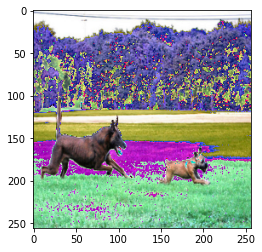

In [ ]:
from matplotlib import cm
import re

pattern = r'\[.*?\]'
example_batch = next(iter(test_dataloader))

idx = 22

def format_output(token_lst):
    string = " ".join([ i if i[0]!='[' else '' for i in tokenizer.convert_ids_to_tokens(token_lst)])
    return string

image, caption = example_batch["image"][idx], example_batch["captions"][idx]
PILtransf =  CVtransforms.ToPILImage()
print(format_output(caption))
plt.imshow(PILtransf(image).convert('RGB'))
image, caption = image.to(device), caption.to(device)

# image = Image.open('./caption/sample/dog_on_road.jpg')
# plt.imshow(image)

# sampleTransforms = CVtransforms.Compose([
#             CVtransforms.Resize((256,256)),
#             CVtransforms.ToTensor(),
#             CVtransforms.Normalize(mean = [0.5], std = [0.5]),
            
#         ])

# image = sampleTransforms(image)




image = image.to(device)
with torch.no_grad():
    features = encoder(torch.unsqueeze(image,0)).unsqueeze(1)
    #output = decoder.sample(features)
    output = decoder.modified_beam_search(features,beams=3)
    
#print(probdic)
print(output)
#print(tokenizer.convert_ids_to_tokens(output))
print(f'predicted: {format_output(output)}')